In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
import torch
from celluloid import Camera
from matplotlib.backend_bases import FigureCanvasBase
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import timeit

import pandas as pd

from src.environment_old import LogEnv_old
from src.utils import path_distance_new, check_missing_vertexes_jampr, create_dataset

from src.or_functions import compute_distance

#from src.environment import LogEnv
#from src.train import train
#from src.architecture import AttentionModel
#from src.evaluation import compute_mean_metric, compute_data_metric, compute_mean_metric_with_or
#from src.vizualisation import demonstration, action_animation
from src.environment_jampr_real import LogEnv
from src.architecture_jampr_2 import AttentionModel
from src.train_jampr import train
from src.or_functions_jampr import compute_distance
from src.evaluation_jampr import compute_mean_metric, compute_mean_metric_with_or, compute_metric_on_data
from src.vizualisation_jampr import demonstration, env_plot

import GPUtil
from pytorch_memlab import LineProfiler, MemReporter

## Отладка

In [ ]:
env = LogEnv(n=20, batch_size=2, active_num=1, K=5)
env.reset()
'a'

In [ ]:
model = AttentionModel(active_num=1).to('cuda')
#model.eval()
'a'
#model.load_state_dict(weights)

In [ ]:
r

In [ ]:
r2

In [ ]:
v[0][0], v[0][1]

In [ ]:
v

In [ ]:
features, d, mask = env.reset(full_reset=False)

print(features)
print(mask)
flag = False
while not flag:
    v1 = int(input())
    v2 = int(input())
    v = torch.tensor([v1, v2]).view(1, -1)
    v1 = int(input())
    v2 = int(input())
    v_m = torch.tensor([v1, v2]).view(1, -1)
    v = torch.cat([v, v_m], dim=0)
    print(v)
    print(mask[0, v[0][1]], mask[1, v[1][1]])
    features, mask, flag = env.step(v)
    print(features[1][:, :, -1])
    features = list(map(lambda x: x.to('cuda'), features))
    print(mask)
    print(flag)
print(env.tour_plan)

#18, 19, 17, 3, 8, 9, 5, 13, 2, 15, 1, 21
#12, 10, 4, 7, 14, 16, 11, 6, 20, 21

#16, 6, 8, 4, 18, 13, 12, 21
#1, 2, 14, 7, 11, 19, 15, 20, 17, 10, 5, 3, 9, 21

In [ ]:
d[1][4, 18]/720

In [ ]:
print(features[2][:, :, 4].sum().to('cpu') + check_missing_vertexes_jampr(env.tour_plan, problem_size) * 10000)

#20 -> 13 -> 2 -> 16 -> 18 -> 15 -> 14 -> 3
#9 -> 1 -> 17 -> 10 -> 7 -> 8
#19 -> 12 -> 5 -> 11 -> 6 -> 4


#17 -> 9 -> 7 -> 1 -> 19 -> 12 -> 11 -> 6
#13 -> 3
#2 -> 15
#20 -> 5 -> 4 -> 14
#10 -> 8 -> 16 -> 18

In [ ]:
features, _, mask = env.reset(full_reset=True)

In [ ]:
# print(mask)
features, _, mask = env.reset(full_reset=False)
print(features[0][:, :, 3:5])
print(features[0][:, :, 2])
flag = False
while not flag:
    v1 = int(input())
    v2 = int(input())
    v = torch.tensor([v1, v2]).view(1, -1)
    print(v)
    #print(d[0, v[0, 1], :])
    features_new, mask, flag = env.step(v)
    features_new = list(map(lambda x: x.to('cuda'), features_new))
    print(features_new[1][:, :, -1])
    print(mask)
    print(flag)
print(env.tour_plan)
print(env.vehicle[:, :, 4].sum().to('cpu') + check_missing_vertexes_jampr(env.tour_plan, 20))

#4 -> 3 -> 14 -> 17 -> 7 -> 16 -> 21
#8 -> 20 -> 1 -> 12 -> 2 -> 11-> 21 
#5 -> 13 -> 21
#9 -> 10 -> 15 -> 6 -> 19 -> 18 -> 21

In [ ]:
device = 'cuda'

In [ ]:
problem_size = 50

In [ ]:
#env = LogEnv(n=10, batch_size=1, active_num=1)
features, d, mask = env.reset(full_reset=True)
print(d)
#print(mask)
#print(env.pairs)
print(features[0][:, :, 3:5])
print(features[0][:, :, 2])
flag = False
t = 0
precomputed = None
features[0] = features[0].to(device)
features[1] = features[1].to(device)
flag_done = False
t = 0
precomputed = None
while not flag_done:
    v, _, precomputed = model(features, mask, t, precomputed, False)
    v = v.to('cpu')
    with torch.no_grad():
        print(env.fillness, features[1][:, :, -1])
        features, mask, flag_done = env.step(v)
        features[1] = features[1].to(device)
    t += 1
    #print(flag)
    #print(mask)
print(features[1][:, :, -1])
print(env.tour_plan)

In [ ]:
check_missing_vertexes_jampr(env.tour_plan, 10)


In [ ]:
print(env.vehicle[:, :, 4].sum().to('cpu') + check_missing_vertexes_jampr(env.tour_plan, 10))


#20 -> 13 -> 2 -> 16 -> 18 -> 15 -> 14 -> 3
#9 -> 1 -> 17 -> 10 -> 7 -> 8
#19 -> 12 -> 5 -> 11 -> 6 -> 4

In [ ]:
print(env.vehicle[:, :, 4])

In [ ]:
features, _, mask = env.reset(full_reset=False)

In [ ]:
print(env.tour_plan)

In [ ]:
data = {}
data['time_matrix'] = env.distance.numpy()[0].squeeze()
data['num_vehicles'] = 5
data['time_windows'] = env.tw.numpy()[0].squeeze()
data['demands'] = env.demand.numpy()[0].squeeze()*env.capacity
data['vehicle_capacities'] = [env.capacity]*data['num_vehicles']
data['starts'] = [0]*data['num_vehicles']
data['ends'] = [21]*data['num_vehicles']

In [ ]:
m, r = compute_distance(data, eps=1e-2, time_limit=30)

In [ ]:
data = {}
data['time_matrix'] = env.distance.numpy()[1].squeeze()
data['num_vehicles'] = 5
data['time_windows'] = env.tw.numpy()[1].squeeze()
data['demands'] = env.demand.numpy()[1].squeeze()*env.capacity
data['vehicle_capacities'] = [env.capacity]*data['num_vehicles']
data['starts'] = [0]*data['num_vehicles']
data['ends'] = [21]*data['num_vehicles']

In [ ]:
m2, r2 = compute_distance(data, eps=1e-2, time_limit=30)

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(env.location[:, 1:-1, 0], env.location[:, 1:-1, 1])
plt.scatter(env.location[:, 0, 0], env.location[:, 0, 1], c='r')
for r in routes_model:
    print(env.tw[:, r, :])
    print(env.demand[:, r].sum())
    plt.plot(env.location[:, r, 0].squeeze(), env.location[:, r, 1].squeeze())

In [ ]:
env.location[:, routes[0], 0], env.location[:, routes[0], 1]

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(env.location[:, 1:-1, 0], env.location[:, 1:-1, 1])
plt.scatter(env.location[:, 0, 0], env.location[:, 0, 1], c='r')
for r in routes:
    print(env.tw[:, r, :])
    plt.plot(env.location[:, r, 0].squeeze(), env.location[:, r, 1].squeeze())

In [ ]:
659/720 + 679.7337/720 + 606.1751/720

In [ ]:
data = {}
data['time_matrix'] = env.distance.numpy()[1].squeeze()
data['num_vehicles'] = 10
data['time_windows'] = env.tw.numpy()[1].squeeze()
data['demands'] = env.demand.numpy()[1].squeeze()*env.capacity
data['vehicle_capacities'] = [env.capacity]*data['num_vehicles']
data['pickups_deliveries'] = env.pairs
compute_distance(data, eps=1e-2, time_limit=1)

## Обучение

In [43]:
model = AttentionModel(active_num=1, distance_dim=20)
model = model.to('cuda')

In [46]:
%%time
weights, _, _, _, _ = train(model, device="cuda", problem_size=100, num_vehicles=12,
                            batch_size=64, epochs=100, T=10, lr=1e-4, decay=0.001,
                            return_distances=True)

  5%|████                                                                              | 5/100 [02:03<39:17, 24.81s/it]

KeyboardInterrupt: 

## Анимация

In [ ]:
opts = {'demand_type': {'distribution': 'uniform', 'max_demand':10},
        #'tw_type': {'distribution': 'uniform'},
        #"pickup_and_delivery":True
       }

n = 10
batch_size = 1
env = LogEnv(batch_size=batch_size, n=n, opts=opts)

features, distances, mask = env.reset()

demonstration(env, opts)

In [ ]:
actions_ext = np.array([2, 7, 3, 5, 1, 0, 6, 8, 9, 4])
action_animation(env, opts, actions_ext, '1-OtOPDTW.gif', 500)

In [ ]:
env = LogEnv(n=10, batch_size=1)
env.reset()
print('ready')

In [ ]:
data['time_windows']

In [ ]:
data['time_matrix']

In [ ]:
data['demands']

In [ ]:
data['vehicle_capacities']

In [ ]:
env_plot(env)

In [ ]:
demonstration(env, model, device)

## Проверка модели CVRP, обученной на сервере

In [ ]:
file_name = 'JAMPR_TW1_20_Feb_13_05_57_10_2021'

In [ ]:
f = open('./models/' + file_name + '_best.pkl', 'rb')
weights = pickle.load(f)
f.close()

In [ ]:
file_name = 'JAMPR_TW1_20_Feb__6_11_23_38_2021'

In [ ]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [ ]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [ ]:
file_name = 'JAMPR_TW1_20_Feb__8_20_09_51_2021'

In [ ]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [ ]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [ ]:
file_name = 'JAMPR_TW1_20_Feb_10_14_16_41_2021'

In [ ]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [ ]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [ ]:
file_name = 'JAMPR_TW1_20_Feb_12_17_23_34_2021'

In [ ]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [ ]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [ ]:
file_name = 'JAMPR_TW1_20_Feb_12_18_22_54_2021'

In [ ]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [ ]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [ ]:
file_name = 'JAMPR_TW1_20_Feb_13_05_57_10_2021'

In [ ]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [ ]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.plot(np.ones(len(reward))*5000, )
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
plt.ylim([4000, 14000])
fig.savefig('reward_20_pdcvrptw.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [ ]:
file_name = 'JAMPR_TW1_20_Feb_15_04_32_07_2021'

In [ ]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [ ]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.plot(np.ones(len(reward))*5000)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [ ]:
file_name = 'JAMPR_TW1_20_Feb_15_05_17_10_2021'

In [ ]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()

In [ ]:
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.plot(np.ones(len(reward))*5000, )
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean iteration loss', fontsize=20)
plt.grid()
#fig.savefig('loss_20_twtsp.png')

In [ ]:
model = AttentionModel(active_num=1).to("cuda")
model.load_state_dict(weights)

In [ ]:
model.eval()
print('r')

In [ ]:
%%time
compute_mean_metric(model, device="cuda", n=20, batch_size=1, T=10, sample=True)

In [ ]:
%%time
compute_mean_metric_with_or(model, device="cuda", n=20, batch_size=20, T=1, time_limit=0.5, eps=1e-2)

## JAMPR модифицированной на среде под реальную задачу

In [28]:
file_name = 'jampr_mod_real_100_Mar_14_15_52_29_2021'

In [29]:
f = open('./models/' + file_name + '_loss.pkl', 'rb')
loss = pickle.load(f)
f.close()
f = open('./models/' + file_name + '_reward.pkl', 'rb')
reward = pickle.load(f)
f.close()

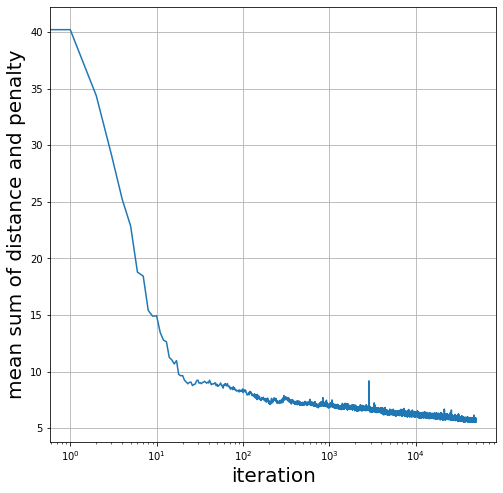

In [30]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [31]:
f = open('./models/' + file_name + '_best.pkl', 'rb')
weights = pickle.load(f)
f.close()

model = AttentionModel(active_num=1)
model = model.to('cuda')

model.load_state_dict(weights)
_ = model.eval()

In [ ]:
%%time
compute_mean_metric_with_or(model, device="cuda", n=100, batch_size=1, T=10, sample=True, time_limit=10)

In [ ]:
1 - 5.56/6.3

## Реальные данные

In [8]:
with open('cvrp_tw_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [ ]:
env = LogEnv(n=100, batch_size=1, active_num=1, K=5)
env.reset(data=dataset[0])
'a'

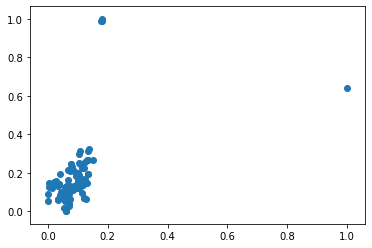

In [5]:
plt.scatter(dataset[0]['coords'][:, 0], dataset[0]['coords'][:, 1])

In [ ]:
num_repeats = []
for i in range(100):
    num_repeats.append((dataset[i]['time_matrix'] == 15).sum())

In [32]:
%%time

model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=1, sample=False, eps=1e-5, K=12)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0.])
tensor([11.])
tensor([11.])
tensor([0.])
tensor([17.])
tensor([1.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([1.])
tensor([0.])
tensor([5.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([6.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([4.])
tensor([10.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([4.])
tensor([3.])
tensor([0.])
tensor([10.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([5.])
tensor([4.])
tensor([0.])
tensor([2.])
tensor([0.])
tensor([2.])
tensor([0.])
tensor([1.])
tensor([5.])
tensor([0.])
tensor([0.])
tensor([1.])
tensor([11.])
tensor([10.])
tensor([10.])
tensor([0.])
tensor([3.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([5.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([13.])
tensor([0.])
tensor([9.])
tensor([0.])
tensor([1.])
tensor([0.])
tensor([0.])
tensor([22.])
tensor([0.])
tensor([5.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([2.])
tensor([0.])
tensor([0.])
te

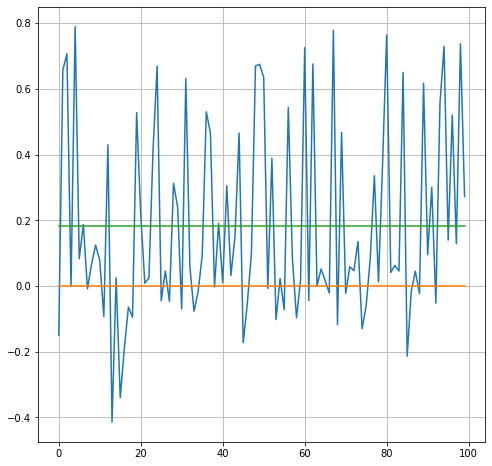

In [33]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.grid()

In [34]:
%%time

model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=10, sample=False, eps=1e-5, K=12)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0.])
tensor([11.])


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\execution.py", line 1312, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "D:\Arseniy\Studies\Sci\CMC6\src\evaluation_jampr.py", line 90, in compute_metric_on_data
    v, _, precomputed = model(features, mask, t, precomputed, sample)
  File "C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "D:\Arseniy\Studies\Sci\CMC6\src\architecture_jampr_2.py", line 166, in forward
    h, h_g = self.encoder(node)
  File "C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "D:\Arseniy\Studies\Sci\CMC6\src\architecture_jampr_2.py", line 70, in forward
    node = module(node)
  File "C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\module.py", line 727, in _

KeyboardInterrupt: 

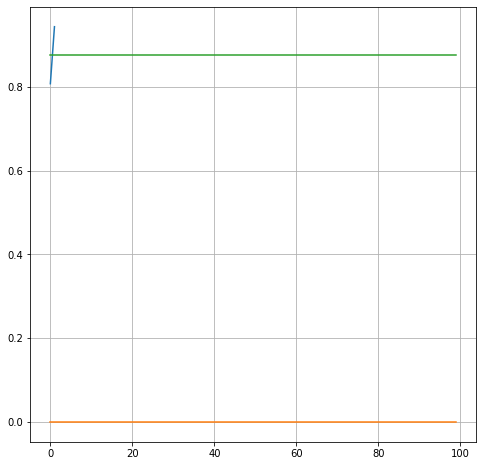

In [35]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.grid()

In [ ]:
num_data = 67

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(dataset[num_data]['coords'][:, 0], dataset[num_data]['coords'][:, 1])
plt.scatter(dataset[num_data]['coords'][0, 0], dataset[num_data]['coords'][0, 1], c='r')
for r in routes[num_data][0].squeeze():
    plt.plot(dataset[num_data]['coords'][r, 0], dataset[num_data]['coords'][r, 1])

## Обучение на реальных графах, но не данных

In [18]:
file_name = 'jampr_mod_real_100_Mar_22_00_33_40_2021'

f = open('./models/' + file_name + '_loss_on_iteration.pkl', 'rb')
loss = pickle.load(f)
f.close()
f = open('./models/' + file_name + '_reward_on_iteration.pkl', 'rb')
reward = pickle.load(f)
f.close()

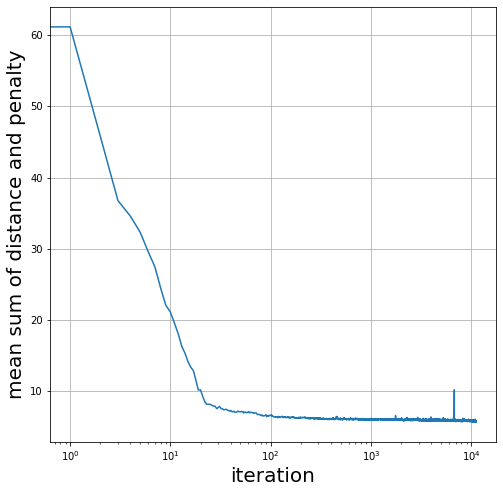

In [4]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

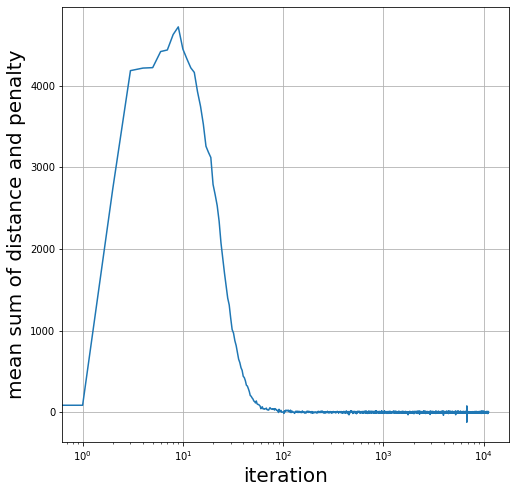

In [5]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [19]:
f = open('./models/' + file_name + '_best_on_iteration.pkl', 'rb')
weights = pickle.load(f)
f.close()

model = AttentionModel(active_num=1)
model = model.to('cuda')

model.load_state_dict(weights)
_ = model.eval()

In [20]:
with open('loc_distance.pkl', 'rb') as f:
    r = pickle.load(f)

In [21]:
compute_mean_metric_with_or(model, n=100, batch_size=1, T=100, time_limit=10, sample=False, eps=1e-5,
                                K=12, r=r, return_distances=False)

-0.027783581444601184

In [9]:
model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=10, sample=False, eps=1e-5, K=12)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

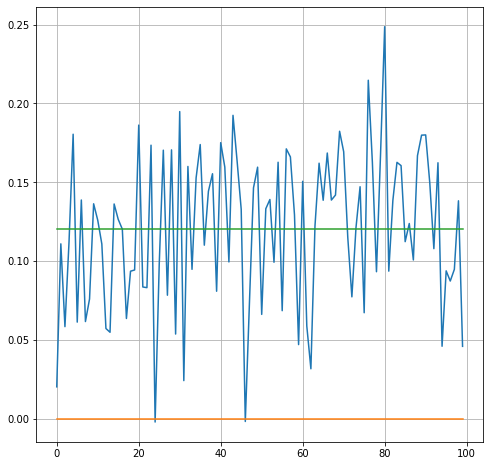

In [13]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.grid()

In [39]:
model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=0.5, sample=False, eps=1e-5, K=12)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

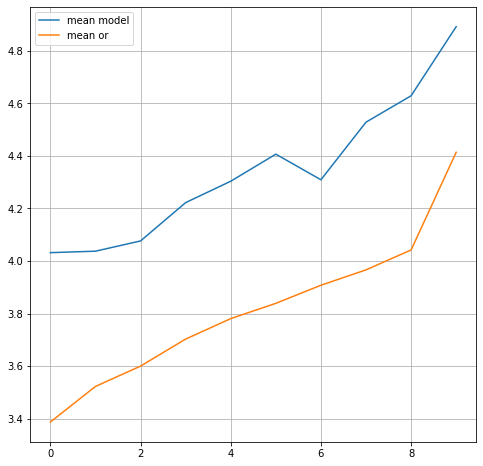

In [33]:
pers = np.percentile(or_metrics, np.arange(10, 101, 10))

bins = (np.array(or_metrics).reshape(-1, 1) <= pers.reshape(1, -1)).argmax(axis=1)

plt.figure(figsize=(8,8))
plt.plot(pd.DataFrame(np.array((model_metrics, or_metrics, bins)).T).groupby(by=2).mean())
plt.grid()
plt.legend(['mean model', 'mean or'])

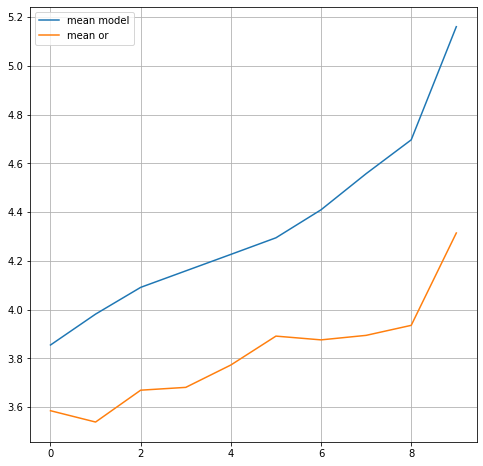

In [32]:
pers = np.percentile(model_metrics, np.arange(10, 101, 10))

bins = (np.array(model_metrics).reshape(-1, 1) <= pers.reshape(1, -1)).argmax(axis=1)

plt.figure(figsize=(8,8))
plt.plot(pd.DataFrame(np.array((model_metrics, or_metrics, bins)).T).groupby(by=2).mean())
plt.grid()
plt.legend(['mean model', 'mean or'])

In [34]:
with open('loc_distance_close.pkl', 'rb') as f:
    r = pickle.load(f)

In [42]:
compute_mean_metric_with_or(model, n=100, batch_size=1, T=100, time_limit=10, sample=False, eps=1e-5,
                                K=12, r=r)

-0.0276303669512133

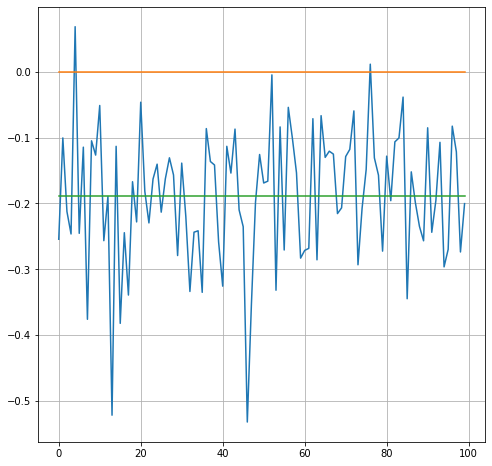

In [40]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.grid()

In [14]:
model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=1, sample=False, eps=1e-5, K=12)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

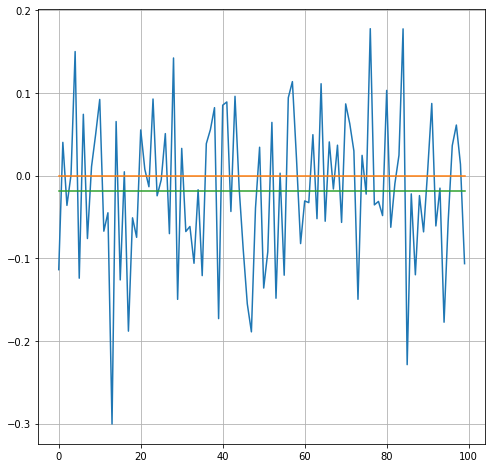

In [15]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.grid()

In [17]:
num_data = 30

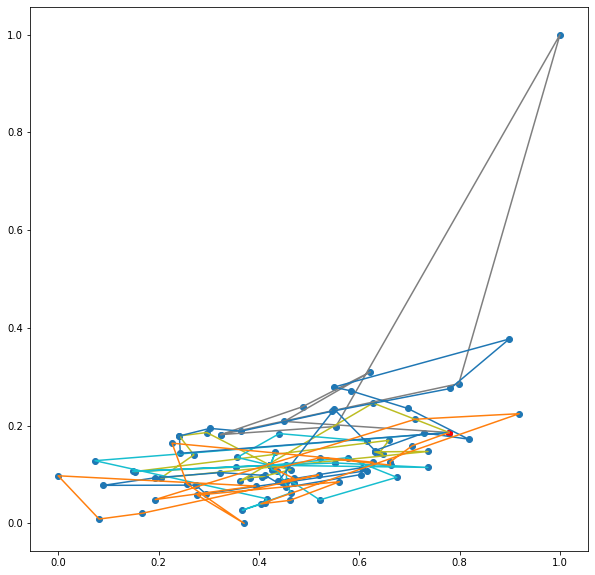

In [18]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(dataset[num_data]['coords'][:, 0], dataset[num_data]['coords'][:, 1])
plt.scatter(dataset[num_data]['coords'][0, 0], dataset[num_data]['coords'][0, 1], c='r')
for r in routes[num_data][1]:
    r = r[1:]
    plt.plot(dataset[num_data]['coords'][r, 0], dataset[num_data]['coords'][r, 1])

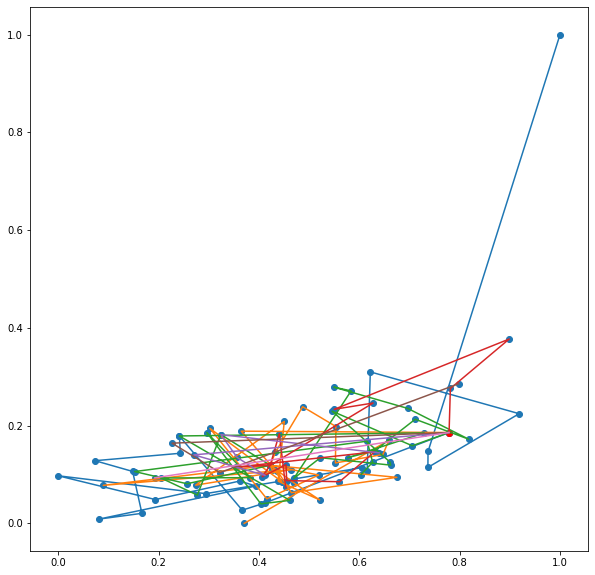

In [19]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(dataset[num_data]['coords'][:, 0], dataset[num_data]['coords'][:, 1])
plt.scatter(dataset[num_data]['coords'][0, 0], dataset[num_data]['coords'][0, 1], c='r')
for r in routes[num_data][0].squeeze():
    plt.plot(dataset[num_data]['coords'][r, 0], dataset[num_data]['coords'][r, 1])

In [23]:
from tqdm import tqdm

In [ ]:
mean_gap = []
std_gap = []

In [ ]:
time_split = np.geomspace(0.3, 10, num=25, endpoint=True)

In [27]:
i = 0
for time in tqdm(time_split, position=0, leave=False):
    if i <= 8:
        i += 1
        continue
    model_metrics = []
    or_metrics = []
    routes = []
    for data in dataset:
        m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=time, sample=False, eps=1e-5, K=12)
        model_metrics.append(m1)
        or_metrics.append(m2)
        routes.append(r)
    mean_gap.append((1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()) 
    std_gap.append((1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).std()) 

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 40%|████████████████████████████████▊                                                 | 10/25 [02:42<04:03, 16.26s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 44%|████████████████████████████████████                                              | 11/25 [05:52<15:56, 68.31s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 48%|██████████████████████████████████████▉                                          | 12/25 [09:28<24:23, 112.55s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 52%|██████████████████████████████████████████                                       | 13/25 [13:30<30:18, 151.58s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 56%|█████████████████████████████████████████████▎                                   | 14/25 [17:39<33:08, 180.77s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 60%|████████████████████████████████████████████████▌                                | 15/25 [22:21<35:09, 210.99s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 64%|███████████████████████████████████████████████████▊                             | 16/25 [27:37<36:23, 242.59s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 68%|███████████████████████████████████████████████████████                          | 17/25 [33:35<36:57, 277.19s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 72%|██████████████████████████████████████████████████████████▎                      | 18/25 [40:21<36:50, 315.81s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 76%|█████████████████████████████████████████████████████████████▌                   | 19/25 [48:03<35:58, 359.69s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 80%|████████████████████████████████████████████████████████████████▊                | 20/25 [56:50<34:10, 410.06s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 84%|██████████████████████████████████████████████████████████████████▎            | 21/25 [1:06:55<31:14, 468.50s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 88%|█████████████████████████████████████████████████████████████████████▌         | 22/25 [1:18:27<26:46, 535.42s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 92%|████████████████████████████████████████████████████████████████████████▋      | 23/25 [1:31:40<20:25, 612.72s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

 96%|███████████████████████████████████████████████████████████████████████████▊   | 24/25 [1:46:51<11:42, 702.12s/it]

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

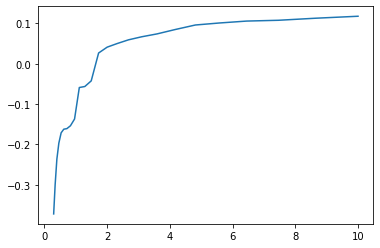

In [29]:
plt.plot(time_split, mean_gap)

## Реальные графы, реальные данные

In [20]:
file_name = 'jampr_mod_real_100_Mar_22_01_12_45_2021'

f = open('./models/' + file_name + '_loss_on_iteration.pkl', 'rb')
loss = pickle.load(f)
f.close()
f = open('./models/' + file_name + '_reward_on_iteration.pkl', 'rb')
reward = pickle.load(f)
f.close()

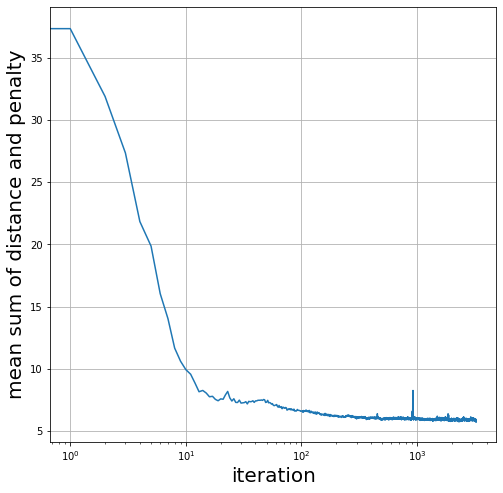

In [21]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

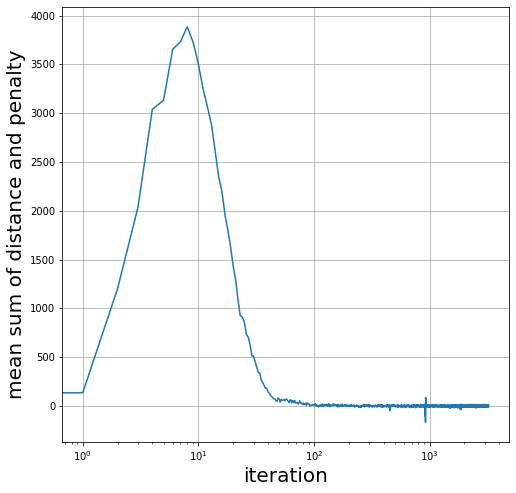

In [22]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(loss)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [23]:
f = open('./models/' + file_name + '_best_on_iteration.pkl', 'rb')
weights = pickle.load(f)
f.close()

model = AttentionModel(active_num=1)
model = model.to('cuda')

model.load_state_dict(weights)
_ = model.eval()

In [24]:
model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=1, sample=False, eps=1e-5, K=12)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

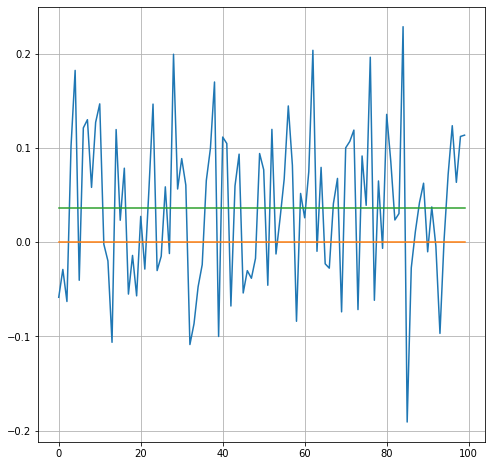

In [25]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.grid()

In [26]:
model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=10, sample=False, eps=1e-5, K=12)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

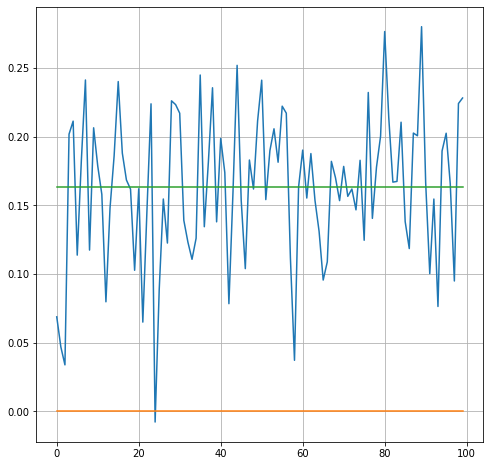

In [27]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.grid()

In [ ]:
model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=30, sample=False, eps=1e-5, K=12)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

In [ ]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.grid()

## С расстояниями с островками

In [13]:
file_name = 'jampr_mod_real_100_Mar_27_13_56_44_2021'

f = open('./models/' + file_name + '_loss_on_iteration.pkl', 'rb')
loss = pickle.load(f)
f.close()
f = open('./models/' + file_name + '_reward_on_iteration.pkl', 'rb')
reward = pickle.load(f)
f.close()

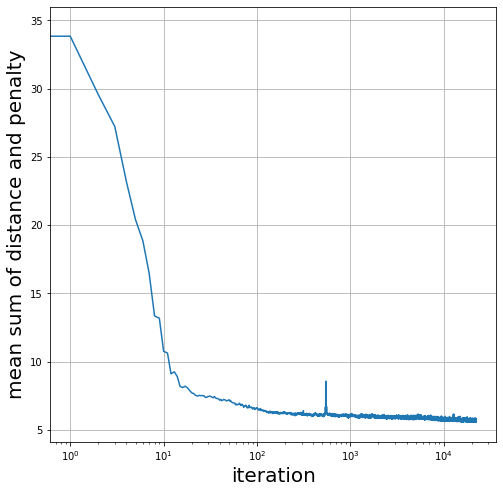

In [14]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()
#fig.savefig('reward_20_twtsp.png')

In [6]:
f = open('./models/' + file_name + '_best_on_iteration.pkl', 'rb')
weights = pickle.load(f)
f.close()

model = AttentionModel(active_num=1, distance_dim=20)
model = model.to('cuda')

model.load_state_dict(weights)
_ = model.eval()

In [7]:
model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=10, sample=False, eps=1e-5, K=12)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

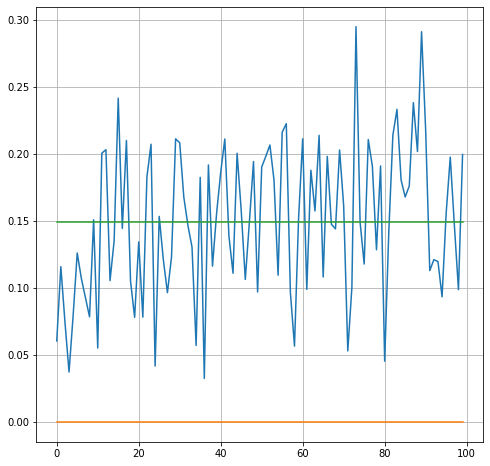

In [8]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.grid()

In [24]:
with open('loc_distance.pkl', 'rb') as f:
    r = pickle.load(f)

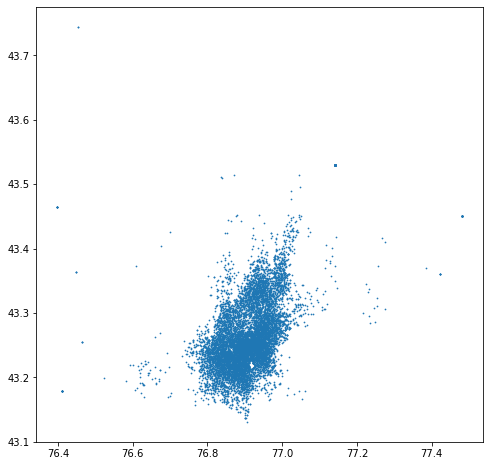

In [25]:
plt.figure(figsize=(8,8))
plt.scatter(np.array(r[1])[:, 0], np.array(r[1])[:, 1], s=0.5)

In [26]:
with open('loc_distance_close.pkl', 'rb') as f:
    r_2 = pickle.load(f)

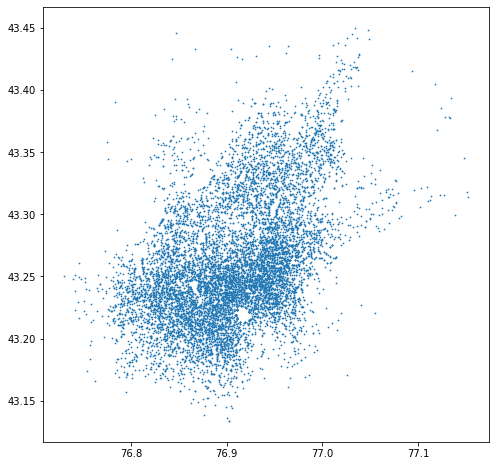

In [27]:
plt.figure(figsize=(8,8))
plt.scatter(np.array(r_2[1])[:, 0], np.array(r_2[1])[:, 1], s=0.5)

In [9]:
compute_mean_metric_with_or(model, n=100, batch_size=1, T=100, time_limit=10, sample=False, eps=1e-5,
                                K=12, r=r)

In [17]:
compute_mean_metric_with_or(model, n=100, batch_size=1, T=100, time_limit=10, sample=False, eps=1e-5,
                                K=12, r=r)

-0.035327820176362046

## Большие острова

In [3]:
file_name = 'jampr_mod_real_100_Mar_30_21_13_07_2021'

f = open('./models/' + file_name + '_loss_on_iteration.pkl', 'rb')
loss = pickle.load(f)
f.close()
f = open('./models/' + file_name + '_reward_on_iteration.pkl', 'rb')
reward = pickle.load(f)
f.close()

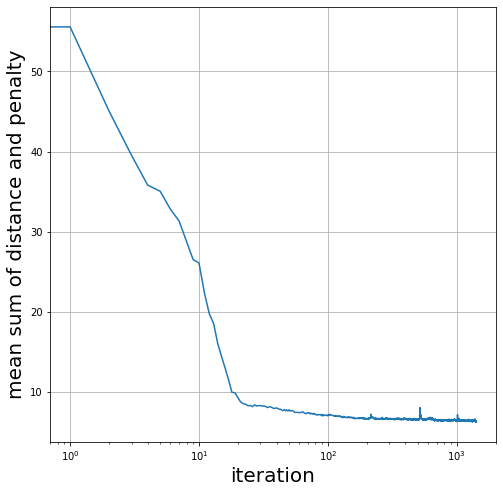

In [4]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
plt.plot(reward)
plt.xlabel('iteration', fontsize=20)
plt.ylabel('mean sum of distance and penalty', fontsize=20)
plt.grid()

In [6]:
f = open('./models/' + file_name + '_best_on_iteration.pkl', 'rb')
weights = pickle.load(f)
f.close()

model = AttentionModel(active_num=1)
model = model.to('cuda')

model.load_state_dict(weights)
_ = model.eval()

In [11]:
model_metrics = []
or_metrics = []
routes = []
for data in dataset:
    m1, m2, r = compute_metric_on_data(model, data, device="cuda", n=100, time_limit=10, sample=False, eps=1e-5, K=12,
                                      return_distances=False)
    model_metrics.append(m1)
    or_metrics.append(m2)
    routes.append(r)

tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])
tensor([0.])

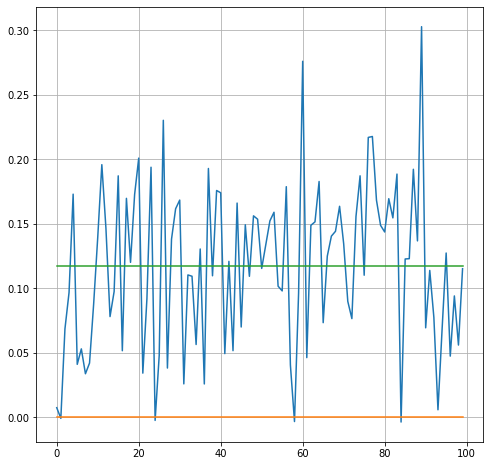

In [12]:
fig = plt.figure(figsize=(8, 8))
plt.plot(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics))
plt.plot(np.arange(100), [0]*100)
plt.plot(np.arange(100), [(1 - torch.tensor(or_metrics)/torch.tensor(model_metrics)).mean()]*100)
plt.grid()